In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run params.py

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [6]:
iggs = [10]
markers = [None,]
color = 'r'
linestyle = '-'

df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wfluxg.dat'), 
                 sep=r'\s+')

df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wcoolrg.dat'), 
                 sep=r'\s+')

for igg, marker in zip(iggs, markers):

    flux_igg = df_wfluxg[df_wfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdx_igg = analysis.model('wgt_igg{}'.format(igg))
    crdx_igg.type_model = 'crd'
    crdx_igg.rundir = DIR_XCRD
    crdx_igg.fpath_flux = s_flux
    crdx_igg.fpath_coolr = s_coolr
    crdx_igg.color = color
    crdx_igg.marker = marker
    crdx_igg.linestyle = linestyle
    crdx_igg.load_data()

In [7]:
iggs = [10]
markers = ['D',]
color = 'g'
linestyle = ':'

df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wwfluxg.dat'), 
                 sep=r'\s+')

df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wwcoolrg.dat'), 
                 sep=r'\s+')

for igg, marker in zip(iggs, markers):

    flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
    crdxx_igg.type_model = 'crd'
    crdxx_igg.rundir = DIR_XCRD
    crdxx_igg.fpath_flux = s_flux
    crdxx_igg.fpath_coolr = s_coolr
    crdxx_igg.color = color
    crdxx_igg.marker = marker
    crdxx_igg.linestyle = linestyle
    crdxx_igg.load_data()

In [8]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [9]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [10]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [11]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [12]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.005

klin =6.375563e-24

nband = 80

ng =9

ng_refs = (/ 3 , 2 , 4 /) 

nref =3

nv = 200

option_klin =1

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 1 , 10 , 500 /) 

t_refs = (/ 250 , 250 , 250 /) 

tsfc =257

vstar = 720

data w_diffuse
     &     /1.7 , 1.6 , 1.8 , 1.8,
     &     1.7 , 1.5 , 1.6 , 1.7,
     &     1.8/

data wgt
     &     /0.6 , 0.4 , 0.7 , 0.7,
     &     0.5 , 0.3 , 0.4 , 0.85,
     &     0.95/

atmosphere_profiles/saw75.pro


In [13]:
fig.display_hrefanchor()

In [14]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [15]:
table_dgdgs.display_hrefanchor()

In [16]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [17]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [18]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

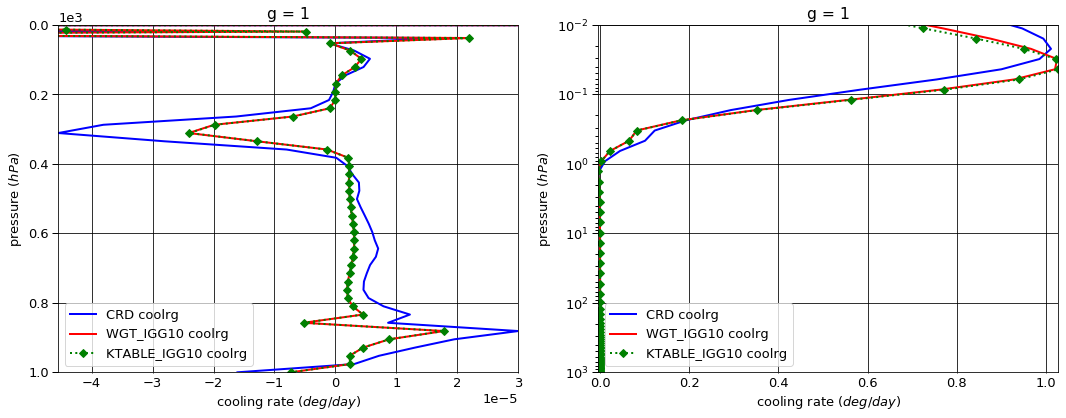

# Figure: cooling rate g-group 2

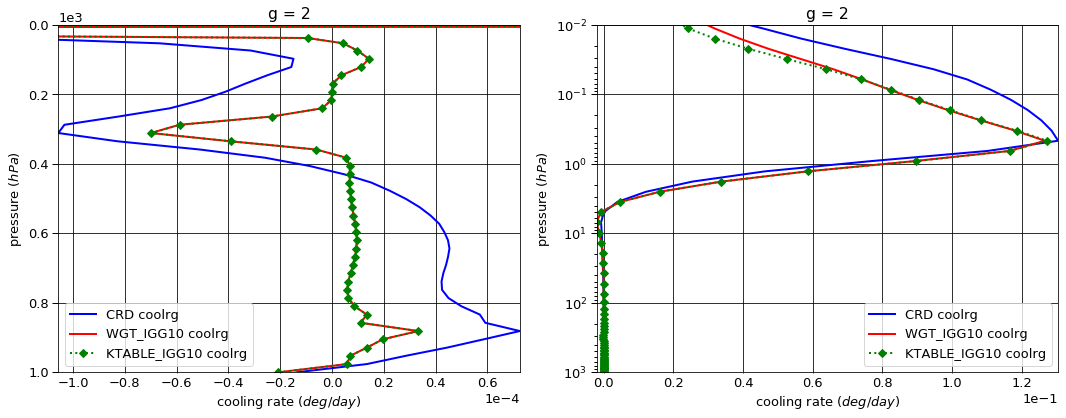

# Figure: cooling rate g-group 3

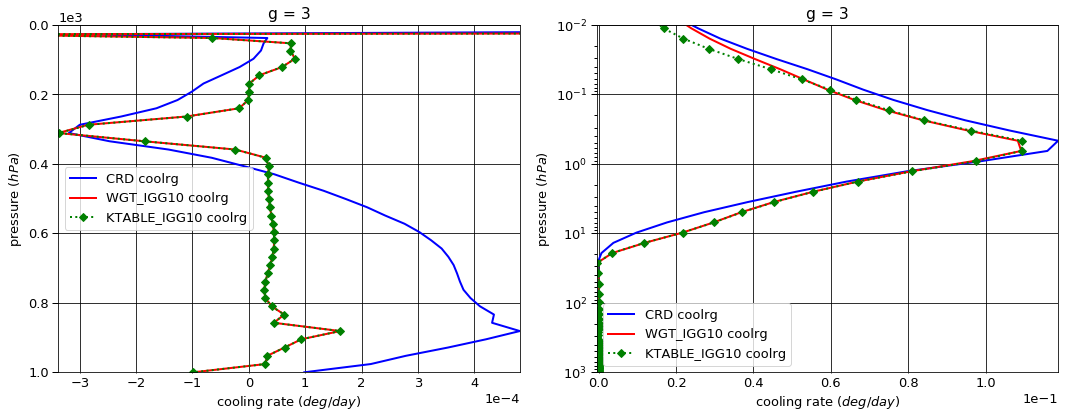

# Figure: cooling rate g-group 4

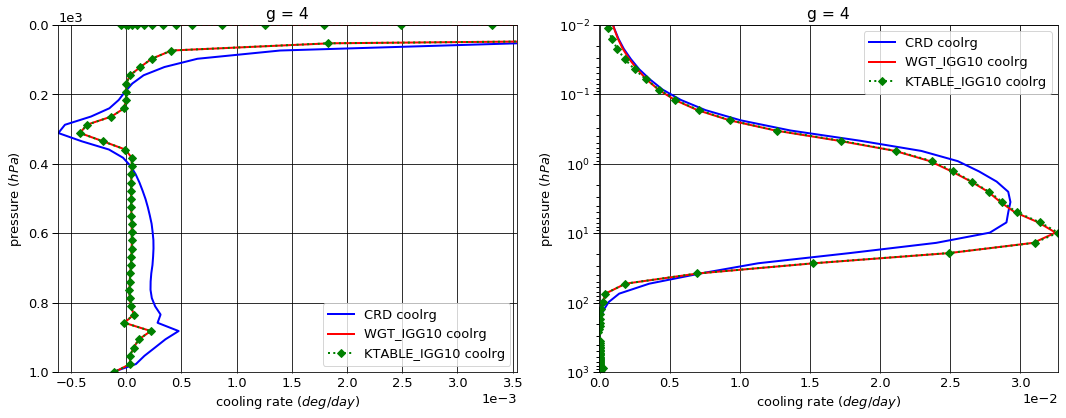

# Figure: cooling rate g-group 5

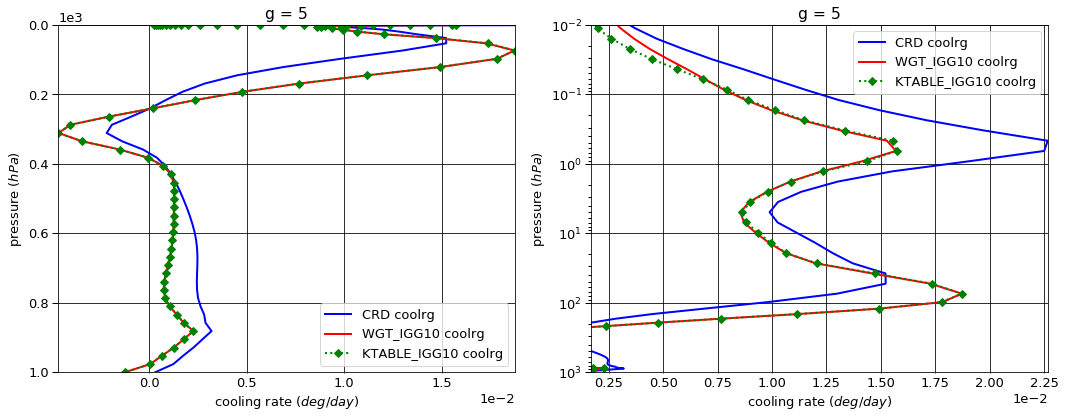

# Figure: cooling rate g-group 6

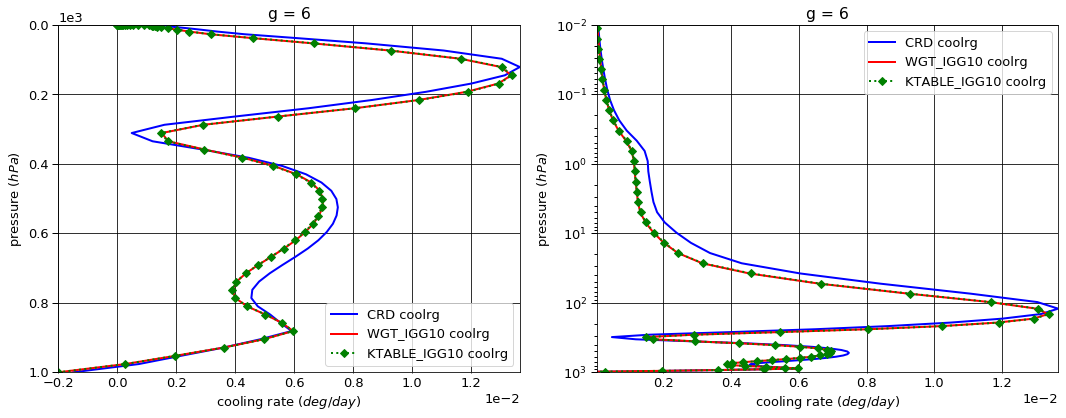

# Figure: cooling rate g-group 7

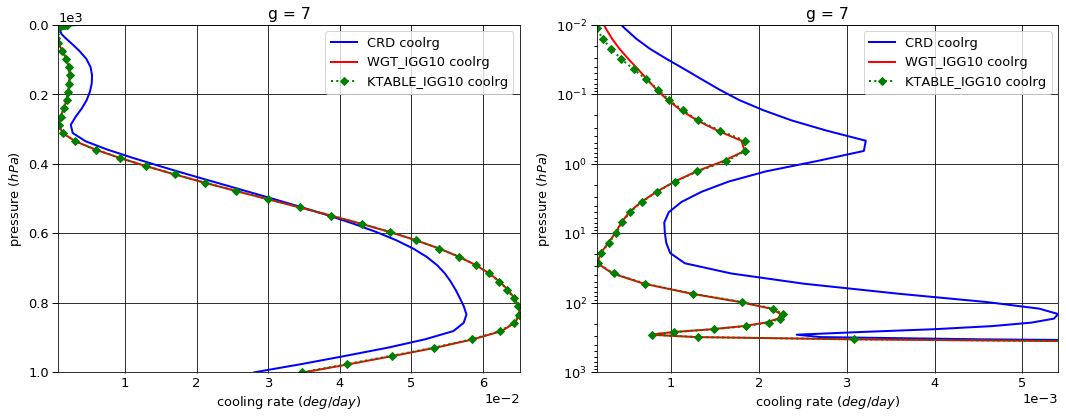

# Figure: cooling rate g-group 8

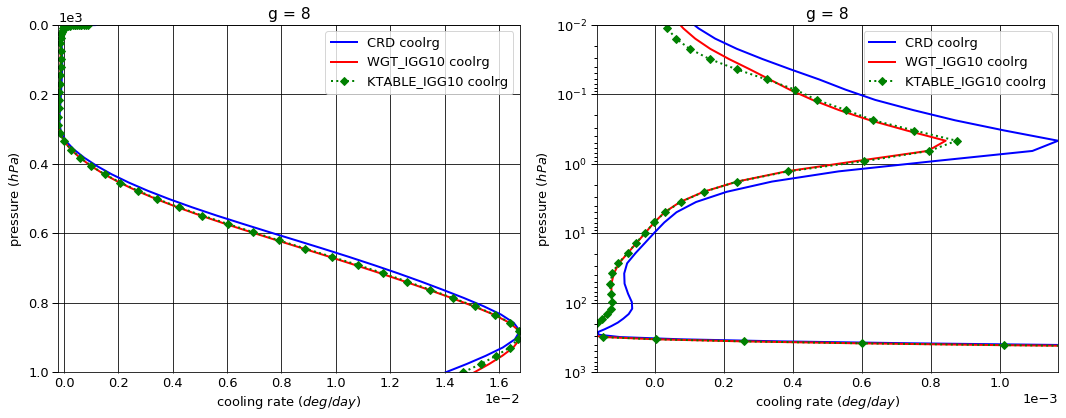

# Figure: cooling rate g-group 9

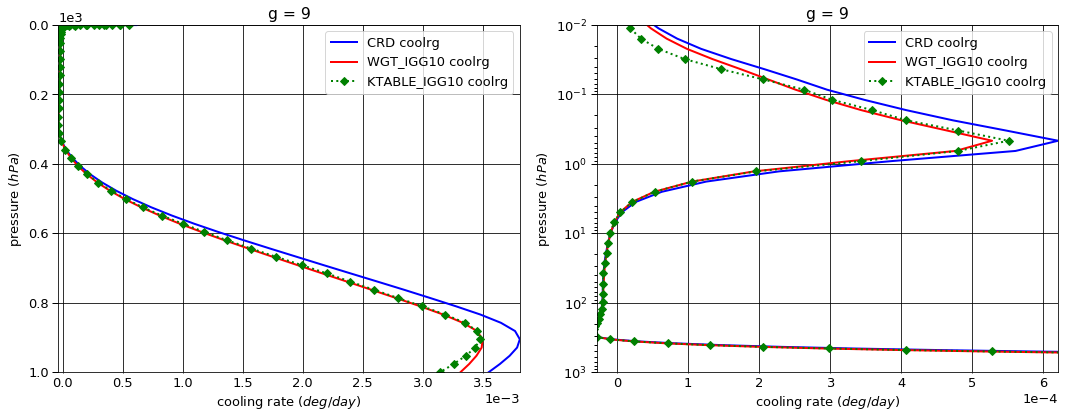

# Figure: cooling rate g-group total

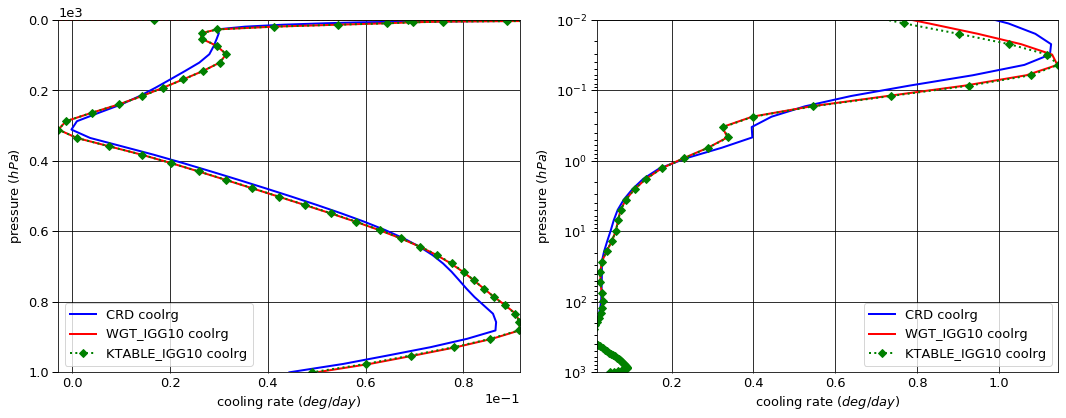

In [19]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [20]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.018786  0.000000 -0.018786
  1013.0   76    -0.022462  0.022536  0.000074
2 0.0      1     -0.018365  0.000000 -0.018365
  1013.0   76    -0.023303  0.023271 -0.000032
3 0.0      1     -0.074702  0.000000 -0.074702
  1013.0   76    -0.121150  0.110691 -0.010458
4 0.0      1     -0.111245  0.000000 -0.111245
  1013.0   76    -0.236245  0.235535 -0.000710
5 0.0      1     -0.411620  0.000000 -0.411620
  1013.0   76    -0.754792  0.692472 -0.062320
6 0.0      1     -0.704505  0.000000 -0.704505
  1013.0   76    -1.340938  1.354253  0.013315
7 0.0      1     -4.493899  0.000000 -4.493899
  1013.0   76    -5.681881  4.581409 -1.100472
8 0.0      1     -3.885526  0.000000 -3.885526
  1013.0   76    -4.013059  0.895213 -3.117847
9 0.0      1     -6.709777  0.000000 -6.709777
  1013.0   76    -6.727693  0.177215 -6.550478


WGT_IGG10


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.018733  0.000000 -0.018733
  1013.0   76    -0.022462  0.022487  0.000025
2 0.0      1     -0.018690  0.000000 -0.018690
  1013.0   76    -0.023303  0.023378  0.000075
3 0.0      1     -0.065800  0.000000 -0.065800
  1013.0   76    -0.121150  0.121501  0.000352
4 0.0      1     -0.108204  0.000000 -0.108204
  1013.0   76    -0.236245  0.236627  0.000382
5 0.0      1     -0.341998  0.000000 -0.341998
  1013.0   76    -0.754792  0.761604  0.006812
6 0.0      1     -0.674073  0.000000 -0.674073
  1013.0   76    -1.340938  1.359244  0.018307
7 0.0      1     -4.560438  0.000000 -4.560438
  1013.0   76    -5.681881  4.700865 -0.981017
8 0.0      1     -3.900707  0.000000 -3.900707
  1013.0   76    -4.013059  0.857633 -3.155427
9 0.0      1     -6.711644  0.000000 -6.711644
  1013.0   76    -6.727693  0.161021 -6.566672


KTABLE_IGG10


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.018794  0.000000 -0.018794
  1013.0   76    -0.022462  0.022487  0.000026
2 0.0      1     -0.018706  0.000000 -0.018706
  1013.0   76    -0.023303  0.023378  0.000075
3 0.0      1     -0.065846  0.000000 -0.065846
  1013.0   76    -0.121150  0.121502  0.000352
4 0.0      1     -0.108234  0.000000 -0.108234
  1013.0   76    -0.236245  0.236627  0.000382
5 0.0      1     -0.341967  0.000000 -0.341967
  1013.0   76    -0.754792  0.761622  0.006831
6 0.0      1     -0.673735  0.000000 -0.673735
  1013.0   76    -1.340938  1.359286  0.018348
7 0.0      1     -4.555652  0.000000 -4.555652
  1013.0   76    -5.681881  4.702107 -0.979775
8 0.0      1     -3.898817  0.000000 -3.898817
  1013.0   76    -4.013059  0.859566 -3.153494
9 0.0      1     -6.711195  0.000000 -6.711195
  1013.0   76    -6.727693  0.161218 -6.566475


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1      5.363800e-05  0.000000  0.000054
  1013.0   76    -3.469447e-18 -0.000048 -0.000048
2 0.0      1     -3.252300e-04  0.000000 -0.000325
  1013.0   76     0.000000e+00  0.000107  0.000107
3 0.0      1      8.902358e-03  0.000000  0.008902
  1013.0   76     0.000000e+00  0.010810  0.010810
4 0.0      1      3.040860e-03  0.000000  0.003041
  1013.0   76     0.000000e+00  0.001092  0.001092
5 0.0      1      6.962193e-02  0.000000  0.069622
  1013.0   76     0.000000e+00  0.069132  0.069132
6 0.0      1      3.043202e-02  0.000000  0.030432
  1013.0   76     0.000000e+00  0.004992  0.004992
7 0.0      1     -6.653880e-02  0.000000 -0.066539
  1013.0   76     0.000000e+00  0.119456  0.119456
8 0.0      1     -1.518070e-02  0.000000 -0.015181
  1013.0   76    -8.881784e-16 -0.037580 -0.037580
9 0.0      1     -1.867100e-03  0.000000 -0.001867
  1013.0   76     0.000000e+00 -0.016194 -0.016194


KTABLE_IGG10 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1     -7.540000e-06  0.000000 -0.000008
  1013.0   76    -3.469447e-18 -0.000048 -0.000048
2 0.0      1     -3.409520e-04  0.000000 -0.000341
  1013.0   76     0.000000e+00  0.000107  0.000107
3 0.0      1      8.856120e-03  0.000000  0.008856
  1013.0   76     0.000000e+00  0.010810  0.010810
4 0.0      1      3.010190e-03  0.000000  0.003010
  1013.0   76     0.000000e+00  0.001092  0.001092
5 0.0      1      6.965323e-02  0.000000  0.069653
  1013.0   76     0.000000e+00  0.069151  0.069151
6 0.0      1      3.077056e-02  0.000000  0.030771
  1013.0   76     0.000000e+00  0.005033  0.005033
7 0.0      1     -6.175340e-02  0.000000 -0.061753
  1013.0   76     0.000000e+00  0.120698  0.120698
8 0.0      1     -1.329110e-02  0.000000 -0.013291
  1013.0   76    -8.881784e-16 -0.035647 -0.035647
9 0.0      1     -1.417700e-03  0.000000 -0.001418
  1013.0   76     0.000000e+00 -0.015997 -0.015997

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer          
1 0.000312    1      0.114054
  1001.112500 75    -0.000016
2 0.000312    1     -0.002257
  1001.112500 75    -0.000014
3 0.000312    1      0.002299
  1001.112500 75     0.000098
4 0.000312    1      0.000110
  1001.112500 75    -0.000128
5 0.000312    1      0.000239
  1001.112500 75     0.000301
6 0.000312    1      0.000010
  1001.112500 75    -0.001499
7 0.000312    1      0.000027
  1001.112500 75     0.028071
8 0.000312    1     -0.000012
  1001.112500 75     0.014043
9 0.000312    1     -0.000011
  1001.112500 75     0.003550


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1     -2.146281e-02
  1001.112500 75    -7.324899e-06
2 0.000312    1      2.198522e-04
  1001.112500 75    -2.070292e-05
3 0.000312    1      3.855335e-03
  1001.112500 75    -9.834198e-05
4 0.000312    1      1.360107e-04
  1001.112500 75    -1.097253e-04
5 0.000312    1      5.495357e-04
  1001.112500 75    -1.255285e-03
6 0.000312    1      8.037727e-06
  1001.112500 75    -2.002217e-03
7 0.000312    1      9.981776e-07
  1001.112500 75     3.505539e-02
8 0.000312    1     -1.408099e-05
  1001.112500 75     1.509646e-02
9 0.000312    1     -9.939423e-06
  1001.112500 75     3.314772e-03


KTABLE_IGG10


coolrg
g pressure    layer              
1 0.000312    1     -2.274144e-02
  1001.112500 75    -7.325728e-06
2 0.000312    1      1.277358e-04
  1001.112500 75    -2.071471e-05
3 0.000312    1      2.050779e-03
  1001.112500 75    -9.838635e-05
4 0.000312    1     -4.796963e-05
  1001.112500 75    -1.098374e-04
5 0.000312    1      2.561858e-04
  1001.112500 75    -1.255315e-03
6 0.000312    1     -1.117320e-06
  1001.112500 75    -1.998396e-03
7 0.000312    1      4.101264e-07
  1001.112500 75     3.469091e-02
8 0.000312    1     -1.583917e-06
  1001.112500 75     1.468700e-02
9 0.000312    1     -6.336702e-08
  1001.112500 75     3.144139e-03


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -1.355166e-01
  1001.112500 75     8.748590e-06
2 0.000312    1      2.476672e-03
  1001.112500 75    -7.097167e-06
3 0.000312    1      1.556501e-03
  1001.112500 75    -1.966800e-04
4 0.000312    1      2.640742e-05
  1001.112500 75     1.827027e-05
5 0.000312    1      3.105896e-04
  1001.112500 75    -1.556470e-03
6 0.000312    1     -2.198154e-06
  1001.112500 75    -5.033331e-04
7 0.000312    1     -2.576051e-05
  1001.112500 75     6.984352e-03
8 0.000312    1     -1.625460e-06
  1001.112500 75     1.053464e-03
9 0.000312    1      6.873587e-07
  1001.112500 75    -2.352052e-04


KTABLE_IGG10 - CRD


coolrg
g pressure    layer          
1 0.000312    1     -0.136795
  1001.112500 75     0.000009
2 0.000312    1      0.002385
  1001.112500 75    -0.000007
3 0.000312    1     -0.000248
  1001.112500 75    -0.000197
4 0.000312    1     -0.000158
  1001.112500 75     0.000018
5 0.000312    1      0.000017
  1001.112500 75    -0.001556
6 0.000312    1     -0.000011
  1001.112500 75    -0.000500
7 0.000312    1     -0.000026
  1001.112500 75     0.006620
8 0.000312    1      0.000011
  1001.112500 75     0.000644
9 0.000312    1      0.000011
  1001.112500 75    -0.000406

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-16.428425,0.000000,-16.428425
1013.0,76,-18.921523,8.092594,-10.828929



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-16.400286,0.00000,-16.400286
1013.0,76,-18.921523,8.24436,-10.677163



KTABLE_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-16.392945,0.000000,-16.392945
1013.0,76,-18.921523,8.247792,-10.673730



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.028139,0.000000,0.028139
1013.0,76,0.000000,0.151766,0.151766



KTABLE_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.035479,0.000000,0.035479
1013.0,76,0.000000,0.155198,0.155198


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,0.114458
1001.112500,75,0.044407



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.016717
1001.112500,75,0.049973



KTABLE_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.020357
1001.112500,75,0.049032



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.131175
1001.112500,75,0.005566



KTABLE_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.134815
1001.112500,75,0.004625


In [21]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.001125,0.001193
2,0.001187,0.001235
3,0.006188,0.006422
4,0.011875,0.012540
5,0.038500,0.040013
6,0.067937,0.071126
7,0.290187,0.301164
8,0.213688,0.211927
9,0.369312,0.354380


In [22]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,2.076063e-19
2,1.947095e-20
3,1.826139e-21
4,1.678020e-21
5,1.581825e-22
6,5.839038e-22
7,6.102842e-23
8,6.378566e-24
9,2.959058e-25


In [23]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [24]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,2.076063e-19,NaN,0.001125,0.001193,0.001125,0.001193,1.0
2,1.947095e-20,0.093788,0.001187,0.001235,0.002312,0.002428,1.0
3,1.826139e-21,0.093788,0.006188,0.006422,0.008500,0.008850,1.0
4,1.678020e-21,0.918890,0.011875,0.012540,0.020375,0.021390,10.0
5,1.581825e-22,0.094267,0.038500,0.040013,0.058875,0.061403,10.0
6,5.839038e-22,3.691330,0.067937,0.071126,0.126812,0.132529,500.0
7,6.102842e-23,0.104518,0.290187,0.301164,0.417000,0.433693,500.0
8,6.378566e-24,0.104518,0.213688,0.211927,0.630687,0.645620,500.0
9,2.959058e-25,0.046391,0.369312,0.354380,1.000000,1.000000,500.0


In [25]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [26]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog      ratio        taulyr
layer g pressure                                                        
1     1 0.000312     5.662447e-19  3.164199e-19   1.789536  2.468427e-03
      2 0.000312     1.617650e-20  9.302846e-21   1.738876  6.379863e-05
      3 0.000312     1.037521e-21  6.851709e-22   1.514252  4.932549e-06
      4 0.000312     1.266240e-23  1.197252e-23   1.057622  6.593259e-08
      5 0.000312     2.178218e-23  1.188558e-23   1.832655  8.910978e-08
      6 0.000312     1.817835e-25  1.799667e-25   1.010095  9.555353e-10
      7 0.000312     3.483701e-25  2.798781e-25   1.244721  1.626553e-09
      8 0.000312     1.687500e-25  7.018410e-26   2.404391  8.150111e-10
      9 0.000312     5.245647e-26  6.564803e-27   7.990563  2.655309e-10
2     1 0.000750     5.793442e-19  3.225460e-19   1.796160  1.016232e-03
      2 0.000750     1.681145e-20  9.663689e-21   1.739651  2.670038e-05
      3 0.000750     1.087781e-21  7.094241e-22   1.533329  2.077290e-06
      4 0.000750     1.357251e-23  1.281217e-23   1.059345  2.845219e-08
      5 0.000750     2.298732e-23  1.233015e-23   1.864317  3.765094e-08
      6 0.000750     1.946903e-25  1.926606e-25   1.010535  4.120781e-10
      7 0.000750     3.699226e-25  2.943750e-25   1.256638  6.920808e-10
      8 0.000750     1.812684e-25  7.313542e-26   2.478531  3.519069e-10
      9 0.000750     5.661040e-26  6.795292e-27   8.330827  1.153908e-10
3     1 0.001052     6.064241e-19  3.352392e-19   1.808929  1.488914e-03
      2 0.001052     1.816283e-20  1.042238e-20   1.742676  4.042166e-05
      3 0.001052     1.195684e-21  7.587050e-22   1.575953  3.183216e-06
      4 0.001052     1.539212e-23  1.446506e-23   1.064090  4.519217e-08
      5 0.001052     2.561692e-23  1.323799e-23   1.935107  5.808977e-08
      6 0.001052     2.216870e-25  2.191490e-25   1.011582  6.575510e-10
      7 0.001052     4.172328e-25  3.252133e-25   1.282951  1.082475e-09
      8 0.001052     2.093158e-25  7.923558e-26   2.641689  5.675297e-10
      9 0.001052     6.599738e-26  7.279973e-27   9.065607  1.885594e-10
4     1 0.001476     6.346425e-19  3.485558e-19   1.820777  2.182151e-03
      2 0.001476     1.963604e-20  1.123912e-20   1.747115  6.123477e-05
      3 0.001476     1.315224e-21  8.101728e-22   1.623387  4.881489e-06
      4 0.001476     1.750093e-23  1.636577e-23   1.069362  7.198381e-08
      5 0.001476     2.859415e-23  1.418929e-23   2.015192  8.973332e-08
      6 0.001476     2.529995e-25  2.498185e-25   1.012733  1.051934e-09
      7 0.001476     4.712000e-25  3.589933e-25   1.312559  1.694166e-09
      8 0.001476     2.419998e-25  8.566435e-26   2.824976  9.167643e-10
      9 0.001476     7.703948e-26  7.801936e-27   9.874406  3.086410e-10
5     1 0.002070     6.636534e-19  3.623544e-19   1.831504  3.195543e-03
      2 0.002070     2.122177e-20  1.210571e-20   1.753038  9.267810e-05
      3 0.002070     1.445994e-21  8.631432e-22   1.675265  7.478779e-06
      4 0.002070     1.992736e-23  1.853523e-23   1.075108  1.147860e-07
      5 0.002070     3.192533e-23  1.516997e-23   2.104509  1.385432e-07
      6 0.002070     2.890120e-25  2.850265e-25   1.013983  1.683996e-09
      7 0.002070     5.320438e-25  3.954472e-25   1.345423  2.648092e-09
      8 0.002070     2.796158e-25  9.236437e-26   3.027313  1.479872e-09
      9 0.002070     8.986452e-26  8.357233e-27  10.752904  5.047428e-10
6     1 0.002904     6.934445e-19  3.766500e-19   1.841084  4.677221e-03
      2 0.002904     2.292752e-20  1.302302e-20   1.760538  1.401765e-04
      3 0.002904     1.588960e-21  9.175990e-22   1.731650  1.145153e-05
      4 0.002904     2.273371e-23  2.102420e-23   1.081311  1.833898e-07
      5 0.002904     3.565263e-23  1.617820e-23   2.203745  2.138811e-07
      6 0.002904     3.305843e-25  3.255916e-25   1.015334  2.699484e-09
      7 0.002904     6.006519e-25  4.346872e-25   1.381802  4.135379e-09
      8 0.002904     3.228746e-25  9.937347e-26   3.249102  2.388014e-09
      9 0.0

# Histogram of wavenumbers in g-group 1

In [27]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [28]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
